# ODS – Etapa 1 (Clasificación de texto)
**Objetivo:** clasificar opiniones a ODS 1/3/4 con modelos supervisados.
Estructura:
1) Entendimiento de los datos
2) Preparación (TF-IDF)
3) Modelos base 
4) Ajuste de hiperparámetros (GridSearchCV)
5) Interpretación (términos top)
6) Exportables (predicciones y modelo)

## 1. Imports y configuración

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2
from joblib import dump

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Buena practica para reproducibilidad segun la ia 


## 2. Carga de datos

In [11]:

DATA_PATH   = "Datos_proyecto.xlsx"          
TEXT_COL    = "textos"                       
LABEL_COL   = "labels"

xls = pd.ExcelFile(DATA_PATH)
print("Hojas:", xls.sheet_names)
df = pd.read_excel(DATA_PATH, sheet_name=xls.sheet_names[0])
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"textos", LABEL_COL:"labels"})
df.head(10)


Hojas: ['Sheet1']


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


## 3. Entendimiento de Datos
Aca vamos a revisar cosas como:
- Tamaños
- Vacios o NA 
- Longitudes 
- Distribución de los Labels


In [12]:
print("Dimensiones:", df.shape)
display(df.info())

Dimensiones: (2424, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None

In [13]:
# Longitud de textos
df["len_words"] = df["textos"].astype(str).str.split().str.len()
df["len_chars"] = df["textos"].astype(str).str.len()
df[["len_words","len_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
len_words,2424.0,107.924092,35.575349,41.0,81.0,102.0,129.00,260.0
len_chars,2424.0,683.223185,223.563695,303.0,513.0,647.0,809.25,1492.0


In [14]:
# NA y duplicados
print("NA por columna:\n", df.isna().sum())
dup_text = df.duplicated(subset=["textos"]).sum()
dup_both = df.duplicated(subset=["textos","labels"]).sum()
print(f"Duplicados de texto: {dup_text} | Duplicados (texto + etiqueta): {dup_both}")

NA por columna:
 textos       0
labels       0
len_words    0
len_chars    0
dtype: int64
Duplicados de texto: 0 | Duplicados (texto + etiqueta): 0


labels
4    1025
3     894
1     505
Name: count, dtype: int64

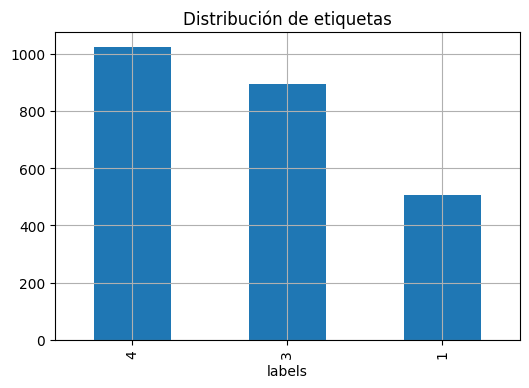

In [15]:
# Distribución de los labels
counts = df["labels"].value_counts()
counts.plot.bar(title="Distribución de etiquetas")
counts

# Los resultados muestran que hay un desbalance en las clases, 
# pero creo que el lunes vamos a revisar eso 
# y como hacer aumentación de datos con ia generativa (Aunque revisé y es para la etapa 2 so don't worry)

In [16]:
df = df.dropna(subset=["textos"]).copy()
df = df[df["textos"].astype(str).str.strip() != ""]
MIN_WORDS = 3
df = df[df["len_words"] > MIN_WORDS].copy()

print("Tras limpieza básica:", df.shape)

# No habian vacios ni duplicados

Tras limpieza básica: (2424, 4)


In [17]:
#Split de datos de entrenamiento y prueba
X = df["textos"].astype(str)
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)


In [28]:
# Stopwords en español, de lo que vi, esto nos va a ayudar ya que hay muchas palabras comunes en los textos
# que no aportan mucho valor para la clasificación y pueden introducir ruido en el modelo y asi nos 
# aseguramos que el modelo se enfoque en las palabras más relevantes para la clasificación (e.g. salud, educación, pobreza, etc)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

spanish_stopwords = stopwords.words("spanish")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yarso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Vectorización TF-IDF, eso es Term Frequency–Inverse Document Frequency (lo vimos en clase)
# Entonces las palabras que aparecen en muchos documentos (alta frecuencia) tienen menos peso
# y las que aparecen en pocos documentos (baja frecuencia) tienen más peso
#Mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",   
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85,
    stop_words=spanish_stopwords
)
# Ajustar 
X_train_tfidf = tfidf.fit_transform(X_train)
# Transformar
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

c:\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', '

((1939, 15856), (485, 15856))

## Modelos
En esta primera iteración vamos a montar arbol de decisión y KNN

In [30]:
# Vamos a probar varios modelos de clasificación con hiperparámetros by feeling a ver como nos va  
models = { 
    "KNN": KNeighborsClassifier(n_neighbors=11, metric="cosine", weights="distance"),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=15, min_samples_leaf=2),
    "Naive Bayes": MultinomialNB(alpha=1.0)
}

In [31]:
# Evaluar modelos 
for name, model in models.items():
    print(f"Modelo: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

Modelo: KNN
              precision    recall  f1-score   support

           1       0.94      0.93      0.94       101
           3       0.96      0.96      0.96       179
           4       0.97      0.97      0.97       205

    accuracy                           0.96       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.96      0.96       485

Modelo: Decision Tree
              precision    recall  f1-score   support

           1       0.90      0.78      0.84       101
           3       0.84      0.92      0.87       179
           4       0.94      0.92      0.93       205

    accuracy                           0.89       485
   macro avg       0.89      0.87      0.88       485
weighted avg       0.89      0.89      0.89       485

Modelo: Naive Bayes
              precision    recall  f1-score   support

           1       0.99      0.75      0.85       101
           3       0.93      0.94      0.94       179
           4       0.

In [ ]:
model = models["KNN"]

model.transform(X_train_tfidf)

tfidf_best = model.named_steps["tfidf"]
Xtr = tfidf_best.transform(X_train)
fn = np.array(tfidf_best.get_feature_names_out())

def top_terms_mean_tfidf(label, topn=15):
    rows = (y_train == label).values
    mean = Xtr[rows].mean(axis=0).A1
    idx = mean.argsort()[::-1][:topn]
    return fn[idx].tolist()

print("ODS1 (mean TF-IDF):", top_terms_mean_tfidf(1))
print("ODS3 (mean TF-IDF):", top_terms_mean_tfidf(3))
print("ODS4 (mean TF-IDF):", top_terms_mean_tfidf(4))

# b) Chi-cuadrado (one-vs-rest)
def top_terms_chi2(label, topn=15):
    y_bin = (y_train == label).astype(int)
    scores, _ = chi2(Xtr, y_bin)
    idx = np.argsort(scores)[-topn:][::-1]
    return fn[idx].tolist()

print("ODS1 (chi2):", top_terms_chi2(1))
print("ODS3 (chi2):", top_terms_chi2(3))
print("ODS4 (chi2):", top_terms_chi2(4))


AttributeError: 'KNeighborsClassifier' object has no attribute 'named_steps'

## Ajuste de Hiperparametros
Como ya tenemos los modelos montados y al evaluarlos vimos que KNN fue el mejor modelo por ahora, vamos a usar GridSearchCV para encontrar los mejores parametros para ese modelo.

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Mejores params: {'knn__metric': 'cosine', 'knn__n_neighbors': 11, 'knn__weights': 'distance', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.96

 KNN (mejor grid) en test 

              precision    recall  f1-score   support

           1      0.941     0.941     0.941       101
           3      0.955     0.955     0.955       179
           4      0.976     0.976     0.976       205

    accuracy                          0.961       485
   macro avg      0.957     0.957     0.957       485
weighted avg      0.961     0.961     0.961       485



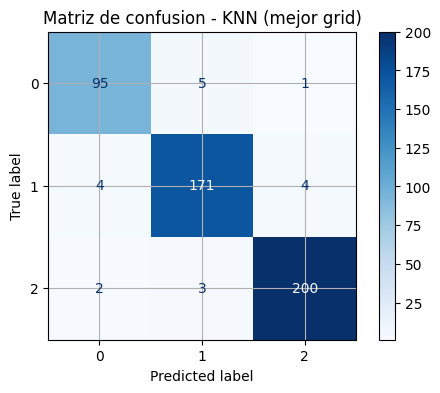

In [ ]:
# Creamos un pipeline para encapsular el proceso de vectorización y el modelo
pipe = Pipeline([
    ("tfidf", tfidf),                 # usa el mismo vectorizador configurado arriba
    ("knn",  KNeighborsClassifier())  # se ajusta en el grid
])

# Definimos el grid de hiperparámetros para KNN
param_grid = {
    "knn__n_neighbors": [3,5,7,9,11,13],
    "knn__weights": ["uniform","distance"],
    "knn__metric": ["cosine","euclidean"],
    "tfidf__min_df": [2,3,5],
    "tfidf__max_df": [0.85,0.9,0.95],
    "tfidf__ngram_range": [(1,1),(1,2),(2,2)]
}

# Configuramos el GridSearchCV
# Usamos StratifiedKFold para mantener la proporción de clases en cada fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe = gs.best_estimator_
print("Mejores params:", gs.best_params_)
print("Mejor F1 macro:", round(gs.best_score_, 2))

# Evaluación en Test, esto no visto por el grid
y_pred = mejor_pipe.predict(X_test)
print("\n KNN (mejor grid) en test \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusion - KNN (mejor grid)")
plt.show()


In [ ]:
tfidf_best = mejor_pipe.named_steps["tfidf"]
Xtr = tfidf_best.transform(X_train)
fn = np.array(tfidf_best.get_feature_names_out())

def top_terms_mean_tfidf(label, topn=15):
    rows = (y_train == label).values
    mean = Xtr[rows].mean(axis=0).A1
    idx = mean.argsort()[::-1][:topn]
    return fn[idx].tolist()

print("ODS1 (mean TF-IDF):", top_terms_mean_tfidf(1))
print("ODS3 (mean TF-IDF):", top_terms_mean_tfidf(3))
print("ODS4 (mean TF-IDF):", top_terms_mean_tfidf(4))

# b) Chi-cuadrado (one-vs-rest)
def top_terms_chi2(label, topn=15):
    y_bin = (y_train == label).astype(int)
    scores, _ = chi2(Xtr, y_bin)
    idx = np.argsort(scores)[-topn:][::-1]
    return fn[idx].tolist()

print("ODS1 (chi2):", top_terms_chi2(1))
print("ODS3 (chi2):", top_terms_chi2(3))
print("ODS4 (chi2):", top_terms_chi2(4))


NameError: name 'mejor_pipe' is not defined